<a href="https://colab.research.google.com/github/SeongwonTak/TIL_swtak/blob/master/210122_Clustering_K_means_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 210122 군집화 : K-means 1

군집화는 비지도학습 중 하나로, **학습 데이터가 없다**.
군집화의 목표는 주어진 데이터 집합을 몇 개의 군집으로 나눠서 의미있는 결과를 만들어내고자 하는 것이다.

군집화의 여러 방법으로는
- prototype based clustering
- hierarchical clustering
- density-based clustering

등등이 있는데, 이번에는 prototype based clustering 중 하나인 **K-means에 대해서 알아보려 한다.**

## 1. K-means란? K-means의 Algorithm

K-means의 주요 특징은 다음과 같다.
- 사전에 cluster 개수 'K'를 지정해야 한다.
- 특성의 유사도에 기초, 샘플을 그룹화한다.

여기서 유사도란, 서로간의 거리를 최소한 가깝게 하는 것으로
다음과 같은 함수의 최소화를 목표로 한다.

$$ J = \sum_{k=1}^{K}\sum_{i \in C_{k}} d(x_{i}, \mu_{k})$$

Remark. 이러한 함수를 **Inertia**라고 한다.

잘 보면 하나의 군집별로, 군집의 중심과 군집내의 점들간의 거리를 합하여, 그것을 최소화 시키고 싶다는 것을 알 수 있다.

이제 알고리즘을 확인해보자

- 1단계. sample들중 임의로 $K$개의 점을 $\mu_{k}$로 지정. 즉 초기 클러스터들의 중심을 선택한다.
- 2단계. 각 sample들과 $\mu_{k}$간의 거리를 비교하여 가장 가까운 샘플로 할당한다.
- 3단계. 이에따라 나온 군집들을 바탕으로 centroid를 재설정한다.
- 4단계. 목표하는 오차범위 이하의 값이 나오거나, 지정한 최대 반복회수가 나올때까지 2~3단계를 반복한다.


## 2. Example of K-means and drawbacks

실제 구현의 예시를 보자.
군집화를 위해 예시 데이터를 만들려고 한다.

In [1]:
from sklearn.datasets import make_blobs
import pandas as pd
import numpy as np
import math
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# make_blobs를 통한 샘플 데이터 형성.
x, y = make_blobs(n_samples=150, centers=4, n_features=2, random_state=3)
points = pd.DataFrame(x, y).reset_index(drop=True)
points.columns = ["x", "y"]
points.head()

,x,y
0,-4.935240,-1.527558
1,-4.639166,1.075836
2,7.428049,7.385592
3,-3.536843,0.529612
4,-0.169088,3.957307


우선 우리는 몇 개의 클러스터로 나눌 것인가에 대해 고민해야 할 것이다. 이를 가장 쉽게 확인하는 법은 당연히, 시각화이다.

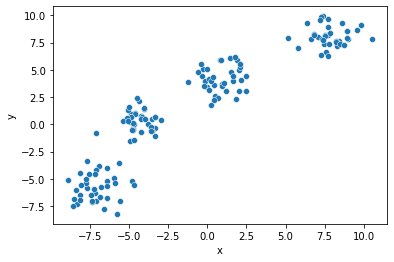

In [7]:
sns.scatterplot(x="x", y="y", data=points)
plt.show()

그림을 보아하니, 딱 봐도 4개의 군집으로 나누면 매우 적합해 보인다.


In [11]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4,
            init='random',
            n_init = 10,
            max_iter = 500,
            tol=1e-04,
            random_state=0)
y_km = km.fit(points)

# 결과 확인
result_by_sklearn = points.copy()
result_by_sklearn["cluster"] = y_km.labels_
result_by_sklearn.head()

,x,y,cluster
0,-4.935240,-1.527558,1
1,-4.639166,1.075836,1
2,7.428049,7.385592,2
3,-3.536843,0.529612,1
4,-0.169088,3.957307,3


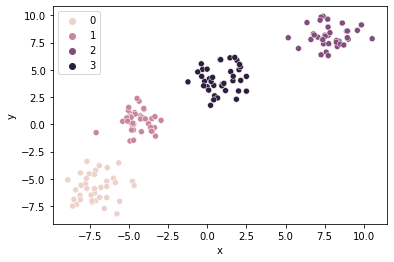

In [12]:
#위의 결과를 시각화하자
sns.scatterplot(x="x", y="y", hue="cluster", data=result_by_sklearn);
plt.legend()
plt.show()

세상이 저거 하나로 깔끔하게 해결되면 얼마나 좋으랴, 하지만 문제점이 없는 것은 아니다.

- 대체 K값은 어떻게 설정해야 하는 것일까?

- 각 클러스터에 적어도 하나의 샘플이 있다고 가정한다.

- 결국 open set 형태와 비슷하게 거리로 잡아 묶어주므로, 데이터셋에 원형 구조가 있다고 가정해버린다. 

- 랜덤으로 선택된 초기 centroid의 위치가 매우 나쁘다면 수렴성이 보장안될수도 있을 것이다.

이러한 문제점을 해결해야 할 것이다. 먼저 마지막 문제부터 해결하자면, 이를 보완한 K-means++ 알고리즘이 존재한다.



## 3. K-means++ Algorithm and Example
**이 알고리즘은 초기 centroid를 서로 멀리 떨어지게 만드는 것이 목표이다.** 따라서, 앞 K-mean의 강화형 버전이며, 알고리즘 1단계의 보완이다.

알고리즘의 내용은 다음과 같다.
- 1단계. 선택할 centroid들을 저장할 빈 집합 $M$을 초기화.
- 2단계. 첫번째 centroid를 랜덤하게 지정하고 $M$에 할당.
- 3단계. $M$에 있지 않은 샘플에 대해, $M$의 centroid까지 최소 제곱 거리를 찾는다.
- 4단계. 최소 제곱거리에 비례한 가중치를 적용한 확률분포를 사용, 다음 centroid를 랜덤하게 사용한다. 구체적으로 다음 가중치를 사용한다.
$$\frac{d(\mu^{(p)},M)^{2}}{\sum_{i}d(x^{(i)},M)^{2}}$$

- 5단계. $K$개의 centroid를 뽑았으면 K-means의 남은 과정 수행

이를 실전에서 활용하는 방법을 알아보자.

In [20]:
# make_blobs를 통한 샘플 데이터 형성.
x2, y2 = make_blobs(n_samples=600, centers=6, n_features=2, random_state=10)
points2 = pd.DataFrame(x2, y2).reset_index(drop=True)
points2.columns = ["x2", "y2"]
points2.head()

,x2,y2
0,1.950344,5.060217
1,5.113584,-9.933843
2,5.020683,-8.803186
3,2.836869,5.805590
4,2.058660,5.813159


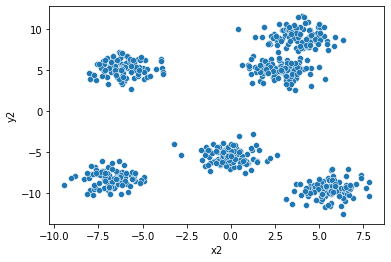

In [21]:
sns.scatterplot(x="x2", y="y2", data=points2)
plt.show()

In [24]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=6,
            init='k-means++',  # 이 부분을 바꿔준다. 사실 생략하면 기본값이 이거다.
            n_init = 20,
            max_iter = 1000,
            tol=1e-04,
            random_state=0)
y_km = km.fit(points2)

# 결과 확인
result_by_sklearn = points2.copy()
result_by_sklearn["cluster"] = y_km.labels_
result_by_sklearn.head()

,x2,y2,cluster
0,1.950344,5.060217,5
1,5.113584,-9.933843,4
2,5.020683,-8.803186,4
3,2.836869,5.805590,5
4,2.058660,5.813159,5


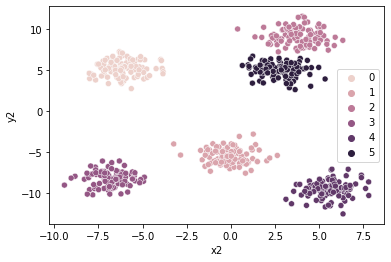

In [26]:
#위의 결과를 시각화하자
sns.scatterplot(x="x2", y="y2", hue="cluster", data=result_by_sklearn);
plt.legend()
plt.show()

그럼 적절한 K값이 실전에선 대체 무엇인지, 이를 답하는 과정을 추후에 알아보고자 한다.